In [ ]:
! git clone https://github.com/credwood/rir_ml.git

In [ ]:
! pip install -r rir_ml/requirements.txt

In [3]:
import sys
sys.path.append('/content/rir_ml')


In [4]:
import logging
from datetime import datetime
import os

import numpy as np
import torch
from torch import optim
from tqdm import tqdm

from core.dataset_utils import RIRHDF5Dataset, denormalize
from core.models import CNN1D
from core.training_utils import WeightedMSELoss


In [5]:
# Mount Google Drive to access your data
from google.colab import drive
drive.mount('/content/drive')

# Now you can use your HDF5 files like this:
rir_path = '/content/drive/MyDrive/rir_data/rir_dataset.h5'
metrics_path = '/content/drive/MyDrive/rir_data/rir_metrics.h5'

Mounted at /content/drive


In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

# Full dataset
full_dataset = RIRHDF5Dataset(rir_path, metrics_path)

indices = list(range(len(full_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Get train targets
train_targets = np.stack([full_dataset[i][1].numpy() for i in train_idx])
target_mean = train_targets.mean(axis=0)
target_std = train_targets.std(axis=0)

train_set = RIRHDF5Dataset(
    rir_path, metrics_path,
    normalize_targets=True,
    target_mean=target_mean,
    target_std=target_std,
    subset_indices=train_idx
)

val_set = RIRHDF5Dataset(
    rir_path, metrics_path,
    normalize_targets=True,
    target_mean=target_mean,
    target_std=target_std,
    subset_indices=val_idx
)


In [7]:
# Set up log file path
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = "training_logs"
os.makedirs(log_dir, exist_ok=True)
log_file = os.path.join(log_dir, f"train_{timestamp}.log")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger()

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from IPython.display import clear_output, display
from collections import defaultdict


def plot_metric_mae(history):
    """
    Plots separate MAE curves for time-based metrics (RT60, EDT, D50) and decibel metric (C50).
    Ensures epoch axis is integer-valued.
    """
    epochs = list(range(1, len(history['mae_rt60']) + 1))

    # Plot time-based metrics (seconds)
    plt.figure(figsize=(10, 5))
    ax1 = sns.lineplot(x=epochs, y=history['mae_rt60'], label='RT60 (s)')
    sns.lineplot(x=epochs, y=history['mae_edt'], label='EDT (s)')
    sns.lineplot(x=epochs, y=history['mae_d50'], label='D50')
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Real-World MAE — Time-Based Metrics")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (seconds)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot C50 (decibels) separately
    plt.figure(figsize=(6, 5))
    ax2 = sns.lineplot(x=epochs, y=history['mae_c50'], label='C50 (dB)', color='orange')
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title("Real-World MAE — C50")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (dB)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def train_model(model, train_dataset, val_dataset, num_epochs=20, batch_size=64, lr=1e-4, device='cuda'):
    """
    Trains the model on normalized metrics, using AdamW and validation-based LR scheduler.
    """
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    metric_weights = torch.tensor([0.5, 3.0, 2.0, 0.5])
    criterion = WeightedMSELoss(metric_weights).to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    best_val_loss = float("inf")
    history = defaultdict(list)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for rirs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            rirs, targets = rirs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(rirs.unsqueeze(1))  # [B, 1, N]
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        mae_sum = torch.zeros(4, device=device)
        num_batches = 0
        with torch.no_grad():
            for rirs, targets in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                rirs, targets = rirs.to(device), targets.to(device)
                outputs = model(rirs.unsqueeze(1))
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                # Denormalize for metric reporting
                outputs_real = denormalize(outputs, val_dataset.target_mean, val_dataset.target_std)
                targets_real = denormalize(targets, val_dataset.target_mean, val_dataset.target_std)
                mae_batch = torch.mean(torch.abs(outputs_real - targets_real), dim=0)
                mae_sum += mae_batch
                num_batches += 1

        avg_val_loss = val_loss / num_batches
        avg_mae = (mae_sum / num_batches).cpu().numpy()

        scheduler.step(avg_val_loss)
        best_val_loss = min(best_val_loss, avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_cnn_model.pt")
            logger.info(f"New best model saved at epoch {epoch+1} with val loss {avg_val_loss:.4f}")

        logger.info(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        logger.info(f"MAE — RT60: {avg_mae[0]:.4f}s | EDT: {avg_mae[1]:.4f}s | C50: {avg_mae[2]:.2f}dB | D50: {avg_mae[3]:.3f}")
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["mae_rt60"].append(avg_mae[0])
        history["mae_edt"].append(avg_mae[1])
        history["mae_c50"].append(avg_mae[2])
        history["mae_d50"].append(avg_mae[3])
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Real-World MAE: RT60={avg_mae[0]:.4f}s, EDT={avg_mae[1]:.4f}s, C50={avg_mae[2]:.2f}dB, D50={avg_mae[3]:.3f}")

        update_training_plot(history)

    return model


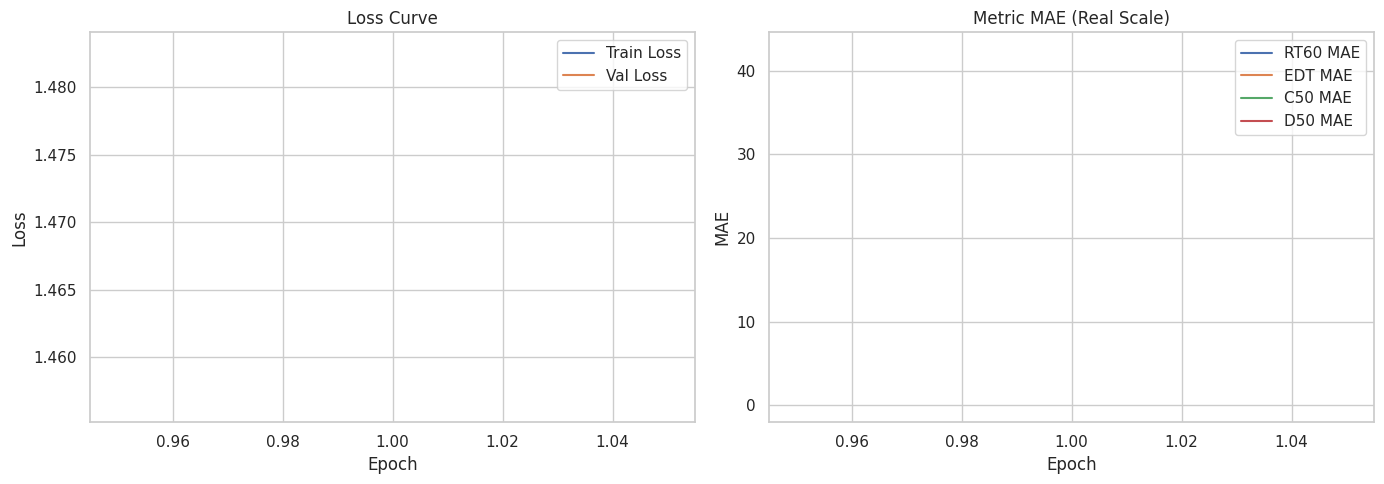

Epoch 2 Training:  18%|█▊        | 7/39 [00:19<01:29,  2.79s/it]


KeyboardInterrupt: 

In [19]:
model = CNN1D()
model = train_model(model, train_set, val_set, num_epochs=20, batch_size=1024, lr=1e-5, device='cuda')